In [24]:
import os
import pandas as pd
import utm
from pyproj import CRS
import hickle as hkl
from scipy.ndimage import zoom
import rasterio
from rasterio.transform import from_origin
import geoarray as ga
import numpy as np
from arosics import COREG_LOCAL
os.chdir(r'C:\Users\Gautam.Mathur\coregout')

In [1]:
#setup
idx=24
data = pd.read_csv(r"C:\Users\Gautam.Mathur\OneDrive - World Resources Institute\Gautam Intern Materials\chm-master-clean.csv")

In [2]:
# import latlong point, use pyproj to find out crs
latitude = data.lat[idx]
longitude = data.lon[idx]


utminfo = utm.from_latlon(latitude, longitude)
if latitude>0:
    bool = False
else: bool = True
crs=CRS.from_dict({'proj':'utm', 'zone' : utminfo[2], 'south': bool})

In [4]:
#import sentinel2 image bands, apply bicubic unsampling to all bands, stack into rasterio object with geographic reference
month=int(data.tile_acq_date[idx][:data.tile_acq_date[idx].find('/')]) # extract month from wv image acquisition date, so correct month of s2 can be selected
s2_path = r"C:\Users\Gautam.Mathur\OneDrive - World Resources Institute\Gautam Intern Materials\sentinel2\chm-sentinel2"
s2=hkl.load(f"{s2_path}\{data.plotid[idx]}.hkl")

#I wonder if the wv2 and 
red = s2[month-1, ..., 2] /65535
green = s2[month-1, :, : ,1] / 65535
blue = s2[month-1, :, :, 0] /65535


newarrays = []
for i in [red, green, blue]:
    img = zoom(i, zoom=4, order=3)
    newarrays.append(img)

pixelsize = 280/newarrays[1].shape[0]
top_left_easting = utminfo[0]-140
top_left_northing = utminfo[1]+140

transform = from_origin(top_left_easting, top_left_northing, pixelsize, pixelsize)

s2raster = rasterio.open('s2.tif', 'w', driver='GTiff', height=newarrays[0].shape[0], 
                         width=newarrays[0].shape[1], dtype='float32', crs=crs, transform=transform, count=3)
s2raster.write(newarrays[0], 1)
s2raster.write(newarrays[1], 2)
s2raster.write(newarrays[2], 3)
s2raster.close()

In [5]:
# import maxar image bands, apply resampling, restack into rasterio object with geographic reference

worldview_path = r'C:\Users\Gautam.Mathur\OneDrive - World Resources Institute\Gautam Intern Materials\worldview-labels-heightpreds\chm-preds'
maxar = rasterio.open(f"{worldview_path}\{data.filename[idx]}").read().astype(np.float32) / 255
maxarrays = [maxar[0], maxar[1], maxar[2]]

##########bicubic resampling
maxar5 = []
for i in maxarrays:
    img = zoom(i, zoom=1/5, order=3)
    maxar5.append(img)

pixelsize = 0.59*maxarrays[1].shape[0]/maxar5[1].shape[0]
top_left_easting = utminfo[0]-70
top_left_northing = utminfo[1]+70
transform = from_origin(top_left_easting, top_left_northing, pixelsize, pixelsize)

wvraster = rasterio.open('wv.tif', 'w', driver='GTiff', height=maxar5[0].shape[0], 
                         width=maxar5[0].shape[1], dtype='float32', crs=crs, transform=transform, count=3)
wvraster.write(maxar5[0], 1)
wvraster.write(maxar5[1], 2)
wvraster.write(maxar5[2], 3)
wvraster.close()
#0.59 m GSD


c:\Users\Gautam.Mathur\env6\lib\site-packages\rasterio\__init__.py:320: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [26]:
#conducting coregistration of unsampled/resampled images. 

im_reference = 'wv.tif'
im_target = 's2.tif'

kwargs = {
    'grid_res' : 2, 
    'window_size' : (18, 18),
    'path_out' : 'auto',
    'projectDir' : r'C:\Users\Gautam.Mathur\coregout',
    'max_shift' : 10, #this is in number of pixels. I wrote 10 because resampled spatial resolution of wv ~ 2.95. There is a default max shift of 5 pixels, so we are expanding max shift in this case. 
    'q' : False,

}
     
CRL = COREG_LOCAL(im_reference,im_target,**kwargs, min_reliability=0)
CRL.correct_shifts()

#misalignment not more than 30-40 m

Warping progress     |===-----------------------------------------------| 5.3% Complete  => 0:00:00

Calculating footprint polygon and actual data corner coordinates for reference image...
Bounding box of calculated footprint for reference image:
	(465101.8727095186, 4447907.772570158, 465252.91270951857, 4448058.812570158)
Calculating footprint polygon and actual data corner coordinates for image to be shifted...
Bounding box of calculated footprint for image to be shifted:
	(465031.8727095186, 4447848.812570158, 465311.8727095186, 4448128.812570158)
Matching window position (X,Y): 465177.39270951855/4447983.292570159
Initializing tie points grid...
Equalizing pixel grids and projections of reference and target image...


Warping progress     |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Calculating tie point grid (961 points) using 8 CPU cores...


	progress: |==================================================| 100.0% Complete  => 0:00:14
c:\Users\Gautam.Mathur\env6\lib\site-packages\arosics\Tie_Point_Grid.py:1196: FutureWarning: `random_state` is a deprecated argument name for `ransac`. It will be removed in version 0.23. Please use `rng` instead.
  ransac((src_coords, est_coords),
c:\Users\Gautam.Mathur\env6\lib\site-packages\arosics\DeShifter.py:291: UserWarning: 
The coordinate grid of s2 cannot be aligned to the desired grid because their pixel sizes are not exact multiples of each other (input [X/Y]: 2.5/2.5; desired [X/Y]: 2.961568627448287/2.9615686275064945). Therefore the original grid is chosen for the resampled output image. If you don´t like that you can use the 'out_gsd' or 'match_gsd' parameters to set an appropriate output pixel size or to allow changing the pixel size.

  warnings.warn("\nThe coordinate grid of %s cannot be aligned to the desired grid because their pixel "
Translating progress |------------------

Found 358 matches.
Performing validity checks...
0 tie points flagged by level 1 filtering (reliability).
133 tie points flagged by level 2 filtering (SSIM).
26 tie points flagged by level 3 filtering (RANSAC)
199 valid tie points remain after filtering.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (112, 112, 3) to C:\Users\Gautam.Mathur\coregout\s2__shifted_to__wv.bsq.


OrderedDict([('band', None),
             ('is shifted', True),
             ('is resampled', True),
             ('updated map info',
              ['UTM',
               1.0,
               1.0,
               465031.8727095186,
               4448128.812570158,
               2.5,
               2.5,
               32,
               'North',
               'WGS-84']),
             ('updated geotransform',
              (465031.8727095186, 2.5, 0.0, 4448128.812570158, 0.0, -2.5)),
             ('updated projection',
              'PROJCS["WGS 84 / UTM zone 32N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",9],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAM

In [8]:
#creating s2 10 m raster, which will later be coregistered using the tie points that have already been generated
pixelsize = 10
top_left_easting = utminfo[0]-140
top_left_northing = utminfo[1]+140
from rasterio.transform import from_origin
transform = from_origin(top_left_easting, top_left_northing, pixelsize, pixelsize)

s2normal = rasterio.open('s2_normal.tif', 'w', driver='GTiff', height=red.shape[0], 
                         width=red.shape[1], dtype='float32', crs=crs, transform=transform, count=3)
s2normal.write(red, 1)
s2normal.write(green, 2)
s2normal.write(blue, 3)
s2normal.close()

In [21]:

from arosics import DESHIFTER
#kwargs = {
 #   'grid_res' : 2, 
  #  'window_size' : (18, 18),
   # 'path_out' : 'auto',
    #'projectDir' : r'C:\Users\Gautam.Mathur\coregout',
    '#q' : False,

#}

array1=DESHIFTER(r'C:\Users\Gautam.Mathur\coregout\s2_normal.tif', CRL.coreg_info).correct_shifts()
arr_data = array1['GeoArray_shifted']
pixelsize = 10
top_left_easting = utminfo[0]-140
top_left_northing = utminfo[1]+140
from rasterio.transform import from_origin
transform = from_origin(top_left_easting, top_left_northing, pixelsize, pixelsize)
s2shifted= rasterio.open ('C:\\Users\\Gautam.Mathur\\coregout\\s2_shifted.tif', 'w', driver='GTiff',height=arr_data.shape[0], 
                         width=arr_data.shape[1], dtype='float32', crs=crs, transform=transform, count=3)
s2shifted.write(arr_data[0], 1)
s2shifted.write(arr_data[1], 2)
s2shifted.write(arr_data[2], 3)
s2shifted.close()

Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |===========================-----------------------| 53.6% Complete  => 0:00:00Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Correcting geometric shifts...
Writing GeoArray of size (28, 28, 3) to auto.


FileNotFoundError: [WinError 3] The system cannot find the path specified: ''

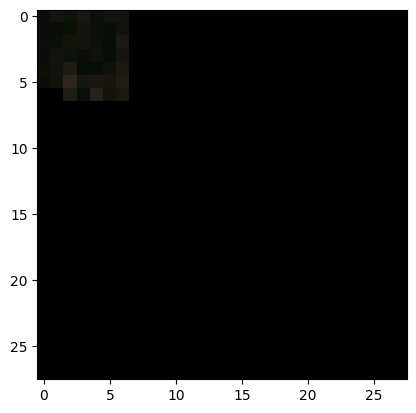

In [49]:
#what the deshifter output looks like right now
plt.imshow(arr_data)
plt.show()